In [1]:
#@title Import Required Libraries
import re
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import random
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#@title Change the Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
#@title Initialise WandB Project
import wandb
# Initialize wandb
wandb.init(project="ANLP Hyperparameter tuning_2")  # Replace with your wandb username

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#@title Helper Functions to Preprocess the Text
def preprocess_text(text):
    """
    Preprocess the text by:
    - Tokenizing sentences
    - Removing special characte
    rs and digits
    - Converting to lowercase
    """
    sentences = sent_tokenize(text)
    cleaned_sentences = []
    for sentence in sentences:
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
        sentence = sentence.lower()
        words = word_tokenize(sentence)
        if words:
            cleaned_sentences.append(words)

    return cleaned_sentences

def load_data(file_path):
    """
    Loads text from a file and returns the cleaned sentences.
    """
    with open(file_path, 'r') as f:
        text = f.read()  # Read the entire text
    return preprocess_text(text)

# Load and preprocess the data
file_path = '/kaggle/input/training/Auguste_Maquet.txt'
sentences = load_data(file_path)


In [ ]:
#@title Build the vocab for the training data.
def build_vocab(sentences, glove_dictionary):
    vocab = {'<UNK>': 0}
    for sent in sentences:
        for word in sent:
            if word in glove_dictionary:
                if word not in vocab:
                    vocab[word] = len(vocab)
    return vocab

In [ ]:
#@title Obtain Glove Embeddings.
glove_dict = {}
with open('/kaggle/input/gloves/glove.6B.300d.txt', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        word_embedding = [float(x) for x in values[1:]]
        glove_dict[word] = word_embedding

In [ ]:
random.shuffle(sentences)
train_split = int(0.7 * len(sentences))
test_split = int(0.9 * len(sentences))

train_sentences = sentences[:train_split]
test_sentences = sentences[train_split:test_split]
val_sentences = sentences[test_split:]

print(f"Train sentences: {len(train_sentences)}")
print(f"Test sentences: {len(test_sentences)}")
print(f"Validation sentences: {len(val_sentences)}")


Train sentences: 24785
Test sentences: 7082
Validation sentences: 3541


In [ ]:
# Load pre-trained embeddings
vocab = build_vocab(train_sentences, glove_dict)

In [ ]:
print(len(vocab))

17268


In [ ]:
index_to_word = {index: word for word, index in vocab.items()}
index = 204
word = index_to_word.get(index, '<UNK>')
print(f"The word with index {index} is '{word}'")

The word with index 204 is 'top'


In [ ]:
embedding_matrix = [glove_dict[word] if word in glove_dict else [0]*300 for word in vocab]

In [ ]:
#@title Input format
def build_ngrams(sentences, vocab, n=5):
    """
    Generate n-grams from tokenized sentences and corresponding labels.

    Parameters:
    - sentences: List of sentences (each sentence is a list of tokens).
    - vocab: Dictionary mapping words to indices.
    - n: Size of the n-gram (default is 5).

    Returns:
    - inputs: List of n-gram inputs (prefixes of length n).
    - labels: Corresponding labels (the next word after each n-gram).
    """
    inputs = []
    labels = []

    for sent in sentences:
        if len(sent) < n + 1:
            continue

        for i in range(len(sent) - n):
            prefix = sent[i:i+n]
            label = sent[i+n]

            encoded_prefix = [vocab.get(word, vocab['<UNK>']) for word in prefix]
            encoded_label = vocab.get(label, vocab['<UNK>'])

            inputs.append(encoded_prefix)
            labels.append(encoded_label)

    return inputs, labels

In [ ]:
train_inputs, train_labels = build_ngrams(train_sentences, vocab, n=5)
test_inputs, test_labels = build_ngrams(test_sentences, vocab, n=5)
val_inputs, val_labels = build_ngrams(val_sentences, vocab, n=5)

In [ ]:
print("Number of samples for training are ",len(train_inputs))
print("Number of samples for testing are ",len(test_inputs))
print("Number of samples for validation are ",len(val_inputs))

Number of samples for training are  540460
Number of samples for testing are  153652
Number of samples for validation are  76500


In [ ]:
#@title Convert input into Tensors.
train_inputs = torch.LongTensor(train_inputs).to(device)
train_labels = torch.LongTensor(train_labels).to(device)
val_inputs = torch.LongTensor(val_inputs).to(device)
val_labels = torch.LongTensor(val_labels).to(device)
test_inputs = torch.LongTensor(test_inputs).to(device)
test_labels = torch.LongTensor(test_labels).to(device)

In [ ]:
train_dataset = TensorDataset(train_inputs, train_labels)
val_dataset = TensorDataset(val_inputs, val_labels)
test_dataset = TensorDataset(test_inputs, test_labels)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
#@title Define NLM class
class NLM(nn.Module):
    def __init__(self, d_embedding, d_hidden, len_vocab, embedding_matrix, n=5):
        """
        Neural Language Model for n-grams using GELU activation.

        Parameters:
        - d_embedding: Dimensionality of word embeddings.
        - d_hidden: Size of the hidden layer.
        - len_vocab: Vocabulary size (output layer).
        - embedding_matrix: Pre-trained word embeddings.
        - n: Length of the n-grams (default 5).
        """
        super(NLM, self).__init__()

        self.n = n  # Allow dynamic n-gram size
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False).to(device)
        self.fc1 = nn.Linear(d_embedding * self.n, d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_hidden)
        self.fc3 = nn.Linear(d_hidden, len_vocab)
        self.dropout = nn.Dropout(0.5)
        self.layer_norm = nn.LayerNorm(d_hidden)  # Adding LayerNorm for stability
        self.gelu = nn.GELU()  # Using GELU activation

    def forward(self, x):
        # Embed input n-grams
        x = self.embeddings(x)  # [batch_size, n, d_embedding]
        x = x.view(x.size(0), -1)  # Flatten the embeddings [batch_size, n * d_embedding]

        # Pass through the network with GELU activation
        x = self.gelu(self.fc1(x))
        x = self.layer_norm(x)  # Normalize
        x = self.dropout(x)

        x = self.gelu(self.fc2(x))
        x = self.layer_norm(x)  # Normalize
        x = self.dropout(x)

        # Output layer (no softmax here, if using CrossEntropyLoss)
        x = self.fc3(x)
        return x

In [ ]:
# Model Parameters
d_embedding = 300
d_hidden = 300
len_vocab = len(vocab)  # Assuming vocab is pre-built
n_gram_size = 5  # Define the n-gram size
learning_rate = 0.01
num_epochs = 10

# Initialize the model, loss function, and optimizer
model = NLM(d_embedding, d_hidden, len_vocab, embedding_matrix, n=n_gram_size).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
# Initialize optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
# Training Loop
model.train()
count_early_stopping = 0
max_tries = 2  # Early stopping patience
best_val_loss = float('inf')

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for val_inputs_batch, val_labels_batch in val_loader:
            # Move inputs and labels to device
            val_inputs_batch, val_labels_batch = val_inputs_batch.to(device), val_labels_batch.to(device)

            # Forward pass
            val_outputs = model(val_inputs_batch)
            loss = loss_fn(val_outputs, val_labels_batch)
            val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Check if validation loss has improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        count_early_stopping = 0  # Reset early stopping counter
        print(f'Best model saved with validation loss: {avg_val_loss:.4f}')
    else:
        count_early_stopping += 1
        print(f'Validation loss did not improve from {best_val_loss:.4f}')

        # Early stopping condition
        if count_early_stopping == max_tries:
            print(f"Early stopping triggered after {count_early_stopping} epochs without improvement.")
            break

Epoch [1/10], Train Loss: 6.1907
Epoch [1/10], Train Loss: 6.1907, Val Loss: 5.6569
Best model saved with validation loss: 5.6569
Epoch [2/10], Train Loss: 5.8529
Epoch [2/10], Train Loss: 5.8529, Val Loss: 5.5372
Best model saved with validation loss: 5.5372
Epoch [3/10], Train Loss: 5.7271
Epoch [3/10], Train Loss: 5.7271, Val Loss: 5.4917
Best model saved with validation loss: 5.4917
Epoch [4/10], Train Loss: 5.6384
Epoch [4/10], Train Loss: 5.6384, Val Loss: 5.4649
Best model saved with validation loss: 5.4649
Epoch [5/10], Train Loss: 5.5630
Epoch [5/10], Train Loss: 5.5630, Val Loss: 5.4506
Best model saved with validation loss: 5.4506
Epoch [6/10], Train Loss: 5.4978
Epoch [6/10], Train Loss: 5.4978, Val Loss: 5.4507
Validation loss did not improve from 5.4506
Epoch [7/10], Train Loss: 5.4427
Epoch [7/10], Train Loss: 5.4427, Val Loss: 5.4564
Validation loss did not improve from 5.4506
Early stopping triggered after 2 epochs without improvement.


In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

/tmp/ipykernel_36/1559688700.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [ ]:
def calculate_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

    avg_loss = total_loss / len(data_loader.dataset)
    perplexity = torch.exp(torch.tensor(avg_loss))
    return avg_loss,perplexity.item()

train_loss,train_perplexity = calculate_perplexity(model, train_loader)
val_loss, val_perplexity = calculate_perplexity(model, val_loader)
test_loss,test_perplexity = calculate_perplexity(model, test_loader)


In [ ]:
print("Loss on the training dataset ",train_loss)
print("Perplexity on the training dataset ",train_perplexity)
print("Loss on the validation dataset ",val_loss)
print("Perplexity on the validation dataset ",val_perplexity)
print("Loss on the test dataset ",test_loss)
print("Perplexity on the test dataset ",test_perplexity)

Loss on the training dataset  5.166131244535888
Perplexity on the training dataset  175.23553466796875
Loss on the validation dataset  5.450633646198022
Perplexity on the validation dataset  232.90567016601562
Loss on the test dataset  5.427621864651622
Perplexity on the test dataset  227.60731506347656


In [ ]:
import torch
import torch.nn.functional as F

def calculate_perplexity_and_save(model, data_loader, file_name):
    model.eval()
    total_loss = 0
    perplexity_scores = []
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # Calculate perplexity for this batch
            batch_perplexity = torch.exp(loss).item()
            perplexity_scores.append((batch_idx, batch_perplexity))

    # Calculate the average loss and perplexity
    avg_loss = total_loss / len(data_loader.dataset)
    avg_perplexity = torch.exp(torch.tensor(avg_loss)).item()

    # Save the batch perplexities and the average to a text file
    with open(file_name, 'w') as f:
        for batch_idx, perplexity in perplexity_scores:
            f.write(f'Batch-{batch_idx+1}\t{perplexity}\n')
        f.write(f'Average\t{avg_perplexity}\n')

# Example usage for train, validation, and test data
calculate_perplexity_and_save(model, train_loader, '2021101075-LM1-train-perplexity.txt')
calculate_perplexity_and_save(model, val_loader, '2021101075-LM1-val-perplexity.txt')
calculate_perplexity_and_save(model, test_loader, '2021101075-LM1-test-perplexity.txt')

In [ ]:
def calculate_accuracy(model, data_loader):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    return accuracy

train_accuracy = calculate_accuracy(model, train_loader)
val_accuracy = calculate_accuracy(model, val_loader)
test_accuracy = calculate_accuracy(model, test_loader)

print(f"Train Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.17469027727910394
Validation Accuracy: 0.14965401357484023
Test Accuracy: 0.15030153384741676


In [ ]:
def visualize_predictions(model, data_inputs, data_labels, index_to_word, num_matches=20, num_mismatches=10):
    model.eval()
    matches_visualized = 0
    mismatches_visualized = 0
    total_visualized = 0

    with torch.no_grad():
        for inputs, labels in zip(data_inputs, data_labels):
            if matches_visualized >= num_matches and mismatches_visualized >= num_mismatches:
                break

            inputs = inputs.unsqueeze(0).to(device)
            labels = labels.unsqueeze(0).to(device)

            outputs = model(inputs)
            _, predicted_label_index = torch.max(outputs, 1)
            predicted_label_index = predicted_label_index.item()
            true_label_index = labels.item()

            input_words = [index_to_word[idx] for idx in inputs.squeeze(0).cpu().numpy()]
            true_label_word = index_to_word.get(true_label_index, '<UNK>')
            predicted_label_word = index_to_word.get(predicted_label_index, '<UNK>')

            # Check if the prediction matches the true label
            is_match = (predicted_label_index == true_label_index)

            if (is_match and matches_visualized < num_matches) or (not is_match and mismatches_visualized < num_mismatches):
                # Print the results
                print(f"Input context: {' '.join(input_words)}")
                print(f"True next word: {true_label_word}")
                print(f"Predicted next word: {predicted_label_word}")
                print("-" * 50)

                # Update counters
                if is_match:
                    matches_visualized += 1
                else:
                    mismatches_visualized += 1
                total_visualized += 1

            if total_visualized >= (num_matches + num_mismatches):
                break
visualize_predictions(model, test_inputs, test_labels, index_to_word, num_matches=20, num_mismatches=10)

Input context: the counts anxiety was manifested
True next word: by
Predicted next word: and
--------------------------------------------------
Input context: counts anxiety was manifested by
True next word: a
Predicted next word: the
--------------------------------------------------
Input context: anxiety was manifested by a
True next word: bright
Predicted next word: man
--------------------------------------------------
Input context: was manifested by a bright
True next word: color
Predicted next word: hand
--------------------------------------------------
Input context: manifested by a bright color
True next word: which
Predicted next word: of
--------------------------------------------------
Input context: by a bright color which
True next word: seldom
Predicted next word: had
--------------------------------------------------
Input context: a bright color which seldom
True next word: appeared
Predicted next word: the
--------------------------------------------------
Input co

#**HYPERPARAMETER TUNING**

In [ ]:
num_epochs=5

In [ ]:
def train_and_evaluate(optimizer_type, d_hidden, dropout_rate):
    # Initialize the model with current hyperparameters
    model = NLM(d_embedding, d_hidden, len_vocab, embedding_matrix, n=n_gram_size).to(device)
    model.dropout = nn.Dropout(dropout_rate).to(device)
    num_epochs=5
    # Choose the optimizer
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer type")

    # Initialize wandb run
    wandb.init(project="language_model", config={
        "optimizer": optimizer_type,
        "d_hidden": d_hidden,
        "dropout_rate": dropout_rate,
        "learning_rate": learning_rate,
        "epochs": num_epochs,
        "n_gram_size": n_gram_size
    })
    wandb.watch(model, log="all", log_freq=10)

    # Training loop
    best_val_loss = float('inf')
    train_loss_list = []
    val_loss_list = []


    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_inputs_batch, val_labels_batch in val_loader:
                val_inputs_batch, val_labels_batch = val_inputs_batch.to(device), val_labels_batch.to(device)
                val_outputs = model(val_inputs_batch)
                loss = loss_fn(val_outputs, val_labels_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            print(f"Validation loss did not improve from {best_val_loss:.4f}")
            break

        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)

        # Log results to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "best_val_loss": best_val_loss
        })

    # Evaluate model on train, validation, and test sets
    model.load_state_dict(torch.load('best_model.pth'))
    train_loss, train_perplexity = calculate_perplexity(model, train_loader)
    val_loss, val_perplexity = calculate_perplexity(model, val_loader)
    test_loss, test_perplexity = calculate_perplexity(model, test_loader)

    # Log final results to wandb
    wandb.log({
        "final_train_perplexity": train_perplexity,
        "final_val_perplexity": val_perplexity,
        "final_test_perplexity": test_perplexity,
        "final_train_loss": train_loss,
        "final_val_loss": val_loss,
        "final_test_loss": test_loss
    })

    return train_perplexity, val_perplexity, test_perplexity, train_loss_list, val_loss_list

In [ ]:
optimizers=['adam','sgd']
d_hidden_values=[200,300,400]
d_dropout_values=[0.3,0.5,0.7]

for opt in optimizers:
    for dim in d_hidden_values:
        for dropout in d_dropout_values:
            train_perplexity, val_perplexity, test_perplexity, train_loss_list, val_loss_list = train_and_evaluate(opt, dim, dropout)
            print(f"Opt: {opt}, d_hidden: {dim}, dropout: {dropout}, Train Perplexity: {train_perplexity}, Val Perplexity: {val_perplexity}, Test Perplexity: {test_perplexity}")

In [ ]:
# Analyze optimizer first
best_optimizer = None
best_optimizer_perplexity = float('inf')
optimizers = ['adam', 'sgd']
optimizers_testppl=[]
optimizers_valppl=[]
for opt in optimizers:
    print(f"Testing optimizer: {opt}")
    _, val_ppl, test_ppl,train_loss,val_loss = train_and_evaluate(opt, d_hidden=300, dropout_rate=0.5)
    optimizers_testppl.append(test_ppl)
    optimizers_valppl.append(val_ppl)
    if test_ppl < best_optimizer_perplexity:
        best_optimizer = opt
        best_optimizer_perplexity = test_ppl

Testing optimizer: adam


best_val_loss,▁
epoch,▁
train_loss,▁
val_loss,▁
best_val_loss,5.7022
epoch,1
train_loss,6.2156
val_loss,5.7022


Epoch [1/5], Train Loss: 6.2035, Val Loss: 5.6840
Epoch [2/5], Train Loss: 5.8616, Val Loss: 5.5552
Epoch [3/5], Train Loss: 5.7346, Val Loss: 5.5093
Epoch [4/5], Train Loss: 5.6431, Val Loss: 5.4643
Epoch [5/5], Train Loss: 5.5681, Val Loss: 5.4490


/tmp/ipykernel_36/1985312428.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Testing optimizer: sgd


best_val_loss,█▄▃▁▁
epoch,▁▃▅▆█
final_test_loss,▁
final_test_perplexity,▁
final_train_loss,▁
final_train_perplexity,▁
final_val_loss,▁
final_val_perplexity,▁
train_loss,█▄▃▂▁
val_loss,█▄▃▁▁
best_val_loss,5.449


Epoch [1/5], Train Loss: 6.1670, Val Loss: 5.6450
Epoch [2/5], Train Loss: 5.7500, Val Loss: 5.4680
Epoch [3/5], Train Loss: 5.6076, Val Loss: 5.3727
Epoch [4/5], Train Loss: 5.5180, Val Loss: 5.2987
Epoch [5/5], Train Loss: 5.4498, Val Loss: 5.2596


## Analysing Results Using the Outputs from WANDB FOR Optimizer Comparision .
- [ADAM](https://wandb.ai/oops-moment-iiit-hyderabad/language_model/runs/g51oby8b/overview)
- [SGD](https://wandb.ai/oops-moment-iiit-hyderabad/language_model/runs/xagiw51h/overview)

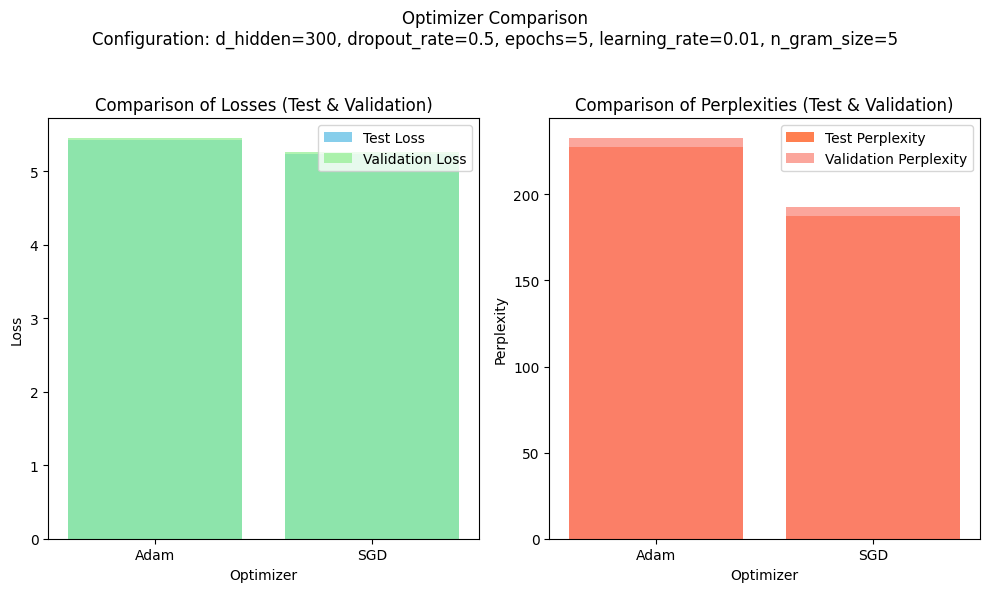

In [2]:
import matplotlib.pyplot as plt

# Configuration details for the experiment
config_details = {
    'd_hidden': 300,
    'dropout_rate': 0.5,
    'epochs': 5,
    'learning_rate': 0.01,
    'n_gram_size': 5
}

# Data for losses and perplexity
optimizers = ['Adam', 'SGD']
test_losses = [5.427753512249956, 5.234631914839392]
val_losses = [5.448979195550259, 5.2959303440855]
test_perplexities = [227.63726806640625, 187.6600341796875]
val_perplexities = [232.5207366943359, 192.40316772460935]

# Plotting loss comparison
plt.figure(figsize=(10, 6))

# Test and Validation Loss
plt.subplot(1, 2, 1)
plt.bar(optimizers, test_losses, color='skyblue', label='Test Loss')
plt.bar(optimizers, val_losses, color='lightgreen', label='Validation Loss', alpha=0.7)
plt.xlabel('Optimizer')
plt.ylabel('Loss')
plt.title('Comparison of Losses (Test & Validation)')
plt.legend()

# Plotting perplexity comparison
plt.subplot(1, 2, 2)
plt.bar(optimizers, test_perplexities, color='coral', label='Test Perplexity')
plt.bar(optimizers, val_perplexities, color='salmon', label='Validation Perplexity', alpha=0.7)
plt.xlabel('Optimizer')
plt.ylabel('Perplexity')
plt.title('Comparison of Perplexities (Test & Validation)')
plt.legend()

# Overall title and configuration display
plt.suptitle('Optimizer Comparison\nConfiguration: d_hidden=300, dropout_rate=0.5, epochs=5, learning_rate=0.01, n_gram_size=5')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Analyze hidden size next
best_hidden_size = None
best_hidden_size_perplexity = float('inf')
hidden_sizes = [200, 300, 400]
hidden_ppl=[]
hidden_val=[AssertionError]
for hidden_size in hidden_sizes:
    print(f"Testing hidden size: {hidden_size}")
    _, val_ppl, test_ppl,train_loss,val_loss = train_and_evaluate(best_optimizer, d_hidden=hidden_size, dropout_rate=0.5)
    hidden_ppl.append(test_ppl)
    hidden_val.append(val_ppl)
    if val_ppl < best_hidden_size_perplexity:
        best_hidden_size = hidden_size
        best_hidden_size_perplexity = test_ppl



Testing hidden size: 200


best_val_loss,█▅▃▂▁
epoch,▁▃▅▆█
train_loss,█▄▂▂▁
val_loss,█▅▃▂▁
best_val_loss,5.33071
epoch,5
train_loss,5.54622
val_loss,5.33071


Epoch [1/5], Train Loss: 6.2511, Val Loss: 5.7062
Epoch [2/5], Train Loss: 5.8287, Val Loss: 5.5345
Epoch [3/5], Train Loss: 5.6926, Val Loss: 5.4356
Epoch [4/5], Train Loss: 5.6076, Val Loss: 5.3746
Epoch [5/5], Train Loss: 5.5450, Val Loss: 5.3266


/tmp/ipykernel_37/1985312428.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Testing hidden size: 300


best_val_loss,█▅▃▂▁
epoch,▁▃▅▆█
final_test_loss,▁
final_test_perplexity,▁
final_train_loss,▁
final_train_perplexity,▁
final_val_loss,▁
final_val_perplexity,▁
train_loss,█▄▂▂▁
val_loss,█▅▃▂▁
best_val_loss,5.32661


Epoch [1/5], Train Loss: 6.1646, Val Loss: 5.6314
Epoch [2/5], Train Loss: 5.7429, Val Loss: 5.4599
Epoch [3/5], Train Loss: 5.6016, Val Loss: 5.3684
Epoch [4/5], Train Loss: 5.5104, Val Loss: 5.3012
Epoch [5/5], Train Loss: 5.4425, Val Loss: 5.2639
Testing hidden size: 400


best_val_loss,█▅▃▂▁
epoch,▁▃▅▆█
final_test_loss,▁
final_test_perplexity,▁
final_train_loss,▁
final_train_perplexity,▁
final_val_loss,▁
final_val_perplexity,▁
train_loss,█▄▃▂▁
val_loss,█▅▃▂▁
best_val_loss,5.26392


Epoch [1/5], Train Loss: 6.1173, Val Loss: 5.5929
Epoch [2/5], Train Loss: 5.6949, Val Loss: 5.4204
Epoch [3/5], Train Loss: 5.5478, Val Loss: 5.3190
Epoch [4/5], Train Loss: 5.4528, Val Loss: 5.2584
Epoch [5/5], Train Loss: 5.3796, Val Loss: 5.2110


## Analysing Results Using the Outputs from WANDB FOR Hidden Dimension Comparision .
- [Dimension 200](https://wandb.ai/oops-moment-iiit-hyderabad/language_model/runs/j9fhwx5u?nw=nwuseroopsmoment)
- [Dimension 300](https://wandb.ai/oops-moment-iiit-hyderabad/language_model/runs/29gaxfur?nw=nwuseroopsmoment)
- [Dimension 400](https://wandb.ai/oops-moment-iiit-hyderabad/language_model/runs/jg0xsci5?nw=nwuseroopsmoment)

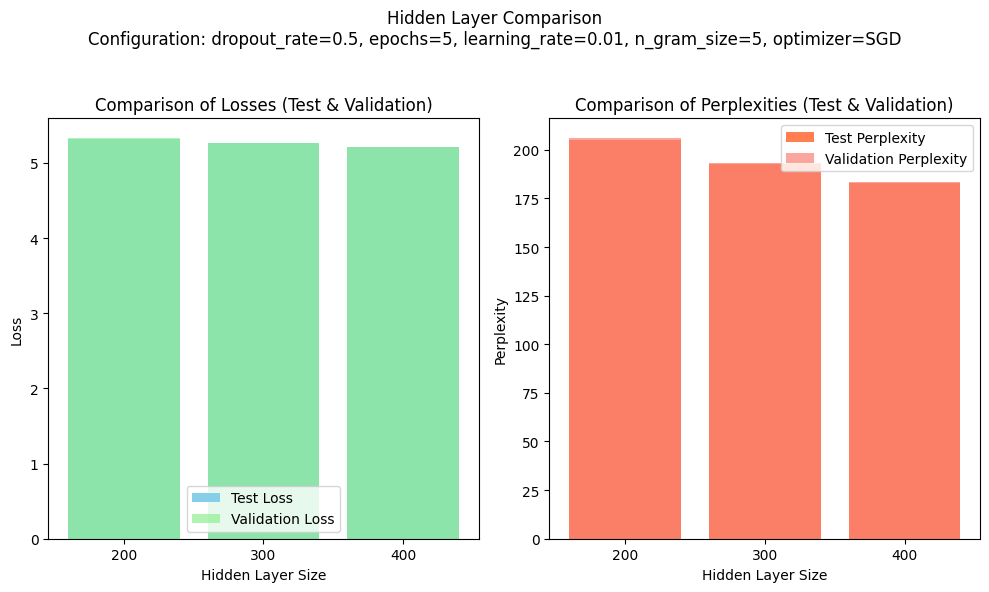

In [3]:
# Configuration details for the experiment
config_details_dim = {
    'dropout_rate': 0.5,
    'epochs': 5,
    'learning_rate': 0.01,
    'n_gram_size': 5,
    'optimizer': 'SGD'
}

# Data for losses and perplexity based on hidden layer size
hidden_layer_sizes = ['200', '300', '400']
test_losses_dim = [5.323763157524252, 5.260798630319545, 5.209553451864311]
val_losses_dim = [5.327147275687822, 5.264528484967799, 5.211575315936718]
test_perplexities_dim = [205.15451049804688, 192.63523864746097, 183.0122833251953]
val_perplexities_dim = [205.84994506835935, 193.3550720214844, 183.38275146484375]

# Plotting loss comparison
plt.figure(figsize=(10, 6))

# Test and Validation Loss for different hidden layer sizes
plt.subplot(1, 2, 1)
plt.bar(hidden_layer_sizes, test_losses_dim, color='skyblue', label='Test Loss')
plt.bar(hidden_layer_sizes, val_losses_dim, color='lightgreen', label='Validation Loss', alpha=0.7)
plt.xlabel('Hidden Layer Size')
plt.ylabel('Loss')
plt.title('Comparison of Losses (Test & Validation)')
plt.legend()

# Plotting perplexity comparison
plt.subplot(1, 2, 2)
plt.bar(hidden_layer_sizes, test_perplexities_dim, color='coral', label='Test Perplexity')
plt.bar(hidden_layer_sizes, val_perplexities_dim, color='salmon', label='Validation Perplexity', alpha=0.7)
plt.xlabel('Hidden Layer Size')
plt.ylabel('Perplexity')
plt.title('Comparison of Perplexities (Test & Validation)')
plt.legend()

# Overall title and configuration display
plt.suptitle('Hidden Layer Comparison\nConfiguration: dropout_rate=0.5, epochs=5, learning_rate=0.01, n_gram_size=5, optimizer=SGD')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Analysing Results Using the Outputs from WANDB FOR Dropout Comparision .
- [Dropout : 0.3](https://wandb.ai/oops-moment-iiit-hyderabad/language_model/runs/841gm3jc?nw=nwuseroopsmoment)

- [Dropout : 0.5 ](https://wandb.ai/oops-moment-iiit-hyderabad/language_model/runs/j61cwf3q)
- [Dropout : 0.7 ](https://wandb.ai/oops-moment-iiit-hyderabad/language_model/runs/t9pfrrfc)

In [ ]:
# Analyze dropout rate last
best_dropout_rate = None
best_dropout_perplexity = float('inf')
dropout_rates = [0.3, 0.5, 0.7]
dropout_ppl=[]
dropout_val=[]

for dropout_rate in dropout_rates:
    print(f"Testing dropout rate: {dropout_rate}")
    _, val_ppl, test_ppl,train_loss,val_loss = train_and_evaluate(best_optimizer, d_hidden=best_hidden_size, dropout_rate=dropout_rate)
    dropout_ppl.append(test_ppl)
    dropout_val.append(val_ppl)
    if val_ppl < best_dropout_perplexity:
        best_dropout_rate = dropout_rate
        best_dropout_perplexity = test_ppl



Testing dropout rate: 0.3


best_val_loss,█▅▃▂▁
epoch,▁▃▅▆█
final_test_loss,▁
final_test_perplexity,▁
final_train_loss,▁
final_train_perplexity,▁
final_val_loss,▁
final_val_perplexity,▁
train_loss,█▄▃▂▁
val_loss,█▅▃▂▁
best_val_loss,5.21101


Epoch [1/5], Train Loss: 5.9485, Val Loss: 5.4748
Epoch [2/5], Train Loss: 5.5019, Val Loss: 5.3034
Epoch [3/5], Train Loss: 5.3333, Val Loss: 5.2064
Epoch [4/5], Train Loss: 5.2156, Val Loss: 5.1505
Epoch [5/5], Train Loss: 5.1235, Val Loss: 5.1132


/tmp/ipykernel_37/1985312428.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Testing dropout rate: 0.5


best_val_loss,█▅▃▂▁
epoch,▁▃▅▆█
final_test_loss,▁
final_test_perplexity,▁
final_train_loss,▁
final_train_perplexity,▁
final_val_loss,▁
final_val_perplexity,▁
train_loss,█▄▃▂▁
val_loss,█▅▃▂▁
best_val_loss,5.11323


Epoch [1/5], Train Loss: 6.1197, Val Loss: 5.5998
Epoch [2/5], Train Loss: 5.6956, Val Loss: 5.4250
Epoch [4/5], Train Loss: 5.4503, Val Loss: 5.2515
Epoch [5/5], Train Loss: 5.3790, Val Loss: 5.2124
Testing dropout rate: 0.7


best_val_loss,█▅▃▂▁
epoch,▁▃▅▆█
final_test_loss,▁
final_test_perplexity,▁
final_train_loss,▁
final_train_perplexity,▁
final_val_loss,▁
final_val_perplexity,▁
train_loss,█▄▃▂▁
val_loss,█▅▃▂▁
best_val_loss,5.21237


Epoch [1/5], Train Loss: 6.3809, Val Loss: 5.7971
Epoch [2/5], Train Loss: 5.9536, Val Loss: 5.6181
Epoch [3/5], Train Loss: 5.8205, Val Loss: 5.5229
Epoch [5/5], Train Loss: 5.6732, Val Loss: 5.4195


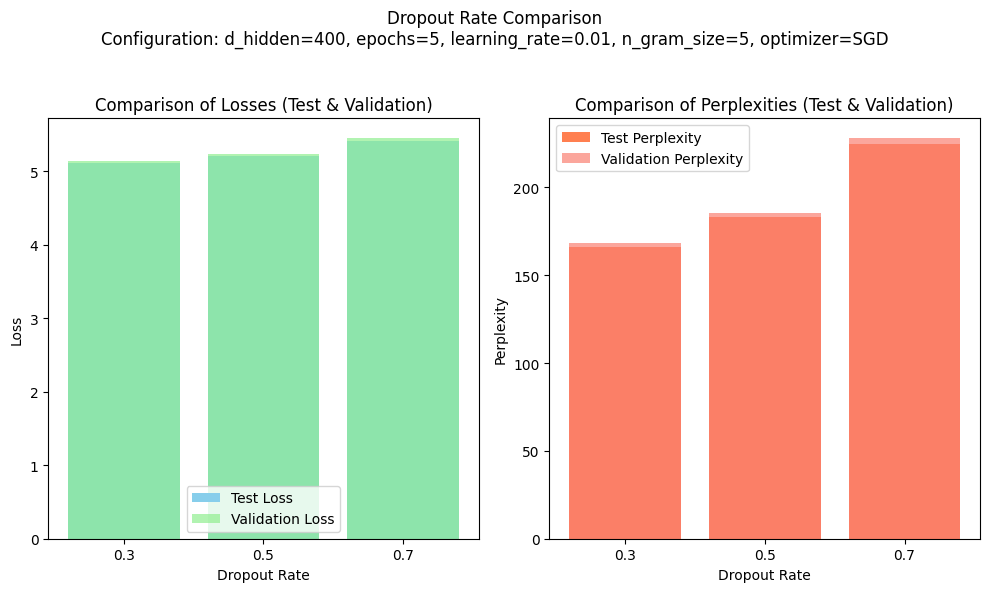

In [5]:
# Configuration details for the experiment
config_details_dropout = {
    'd_hidden': 400,
    'epochs': 5,
    'learning_rate': 0.01,
    'n_gram_size': 5,
    'optimizer': 'SGD'
}

# Data for losses and perplexity based on dropout rate
dropout_rates = ['0.3', '0.5', '0.7']
test_losses_dropout = [5.110677545824702, 5.209722155976977, 5.4136997686095185]
val_losses_dropout = [5.14384553340837, 5.233014258640264, 5.449928296506795]
test_perplexities_dropout = [165.7826690673828, 183.0431671142578, 224.46047973632812]
val_perplexities_dropout = [168.3086395263672, 185.64675903320312, 227.8628692626953]

# Plotting loss comparison
plt.figure(figsize=(10, 6))

# Test and Validation Loss for different dropout rates
plt.subplot(1, 2, 1)
plt.bar(dropout_rates, test_losses_dropout, color='skyblue', label='Test Loss')
plt.bar(dropout_rates, val_losses_dropout, color='lightgreen', label='Validation Loss', alpha=0.7)
plt.xlabel('Dropout Rate')
plt.ylabel('Loss')
plt.title('Comparison of Losses (Test & Validation)')
plt.legend()

# Plotting perplexity comparison
plt.subplot(1, 2, 2)
plt.bar(dropout_rates, test_perplexities_dropout, color='coral', label='Test Perplexity')
plt.bar(dropout_rates, val_perplexities_dropout, color='salmon', label='Validation Perplexity', alpha=0.7)
plt.xlabel('Dropout Rate')
plt.ylabel('Perplexity')
plt.title('Comparison of Perplexities (Test & Validation)')
plt.legend()

# Overall title and configuration display
plt.suptitle('Dropout Rate Comparison\nConfiguration: d_hidden=400, epochs=5, learning_rate=0.01, n_gram_size=5, optimizer=SGD')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
print(f"Best settings: optimizer={best_optimizer}, hidden_size={best_hidden_size}, dropout={best_dropout_rate}")
# Finish wandb run
wandb.finish()

Best settings: optimizer=sgd, hidden_size=400, dropout=0.3


best_val_loss,█▅▃▂▁
epoch,▁▃▅▆█
final_test_loss,▁
final_test_perplexity,▁
final_train_loss,▁
final_train_perplexity,▁
final_val_loss,▁
final_val_perplexity,▁
train_loss,█▄▂▂▁
val_loss,█▅▃▂▁
best_val_loss,5.41947
